In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

csv_file = '../log/160result/out.csv'
# csv_file = '../log/BaselineTest/out.csv'
# df = pd.read_csv(csv_file)
# df = df[df['test_suite']!=4]
# df.to_csv(csv_file, index=False)

In [21]:
df = pd.read_csv(csv_file)

# group by as key_path index_type init_table_size test_suite
df_grouped = df.groupby(['key_path', 'index_type', 'init_table_size', 'test_suite'])

# construct a new dataframe for each group
df_new = pd.DataFrame(columns=['key_path', 'index_type', 'init_table_size', 'test_suite',
                               'insert_throughput_avg', 'insert_throughput_min', 'insert_throughput_max', 'insert_throughput_stdv',
                               'read_throughput_avg', 'read_throughput_min', 'read_throughput_max', 'read_throughput_stdv',
                               'memory_consumption_avg', 'memory_consumption_min', 'memory_consumption_max', 'memory_consumption_stdv'])
for name, group in df_grouped:
    key_path, index_type, init_table_size, test_suite = name
    insert_throughput_avg = group.loc[group['insert_ratio'] == 1, 'throughput'].mean()
    insert_throughput_min= group.loc[group['insert_ratio'] == 1, 'throughput'].min()
    insert_throughput_max= group.loc[group['insert_ratio'] == 1, 'throughput'].max()
    insert_throughput_stdv= group.loc[group['insert_ratio'] == 1, 'throughput'].std()
    read_throughput_avg = group.loc[group['insert_ratio'] == 0, 'throughput'].mean()
    read_throughput_min= group.loc[group['insert_ratio'] == 0, 'throughput'].min()
    read_throughput_max= group.loc[group['insert_ratio'] == 0, 'throughput'].max()
    read_throughput_stdv= group.loc[group['insert_ratio'] == 0, 'throughput'].std()
    memory_consumption_avg = group['memory_consumption'].mean()
    memory_consumption_min= group['memory_consumption'].min()
    memory_consumption_max= group['memory_consumption'].max()
    memory_consumption_stdv= group['memory_consumption'].std()
    df_new.loc[len(df_new)] = [key_path, index_type, init_table_size, test_suite, insert_throughput_avg, insert_throughput_min, insert_throughput_max, insert_throughput_stdv, read_throughput_avg, read_throughput_min, read_throughput_max, read_throughput_stdv, memory_consumption_avg, memory_consumption_min, memory_consumption_max, memory_consumption_stdv]


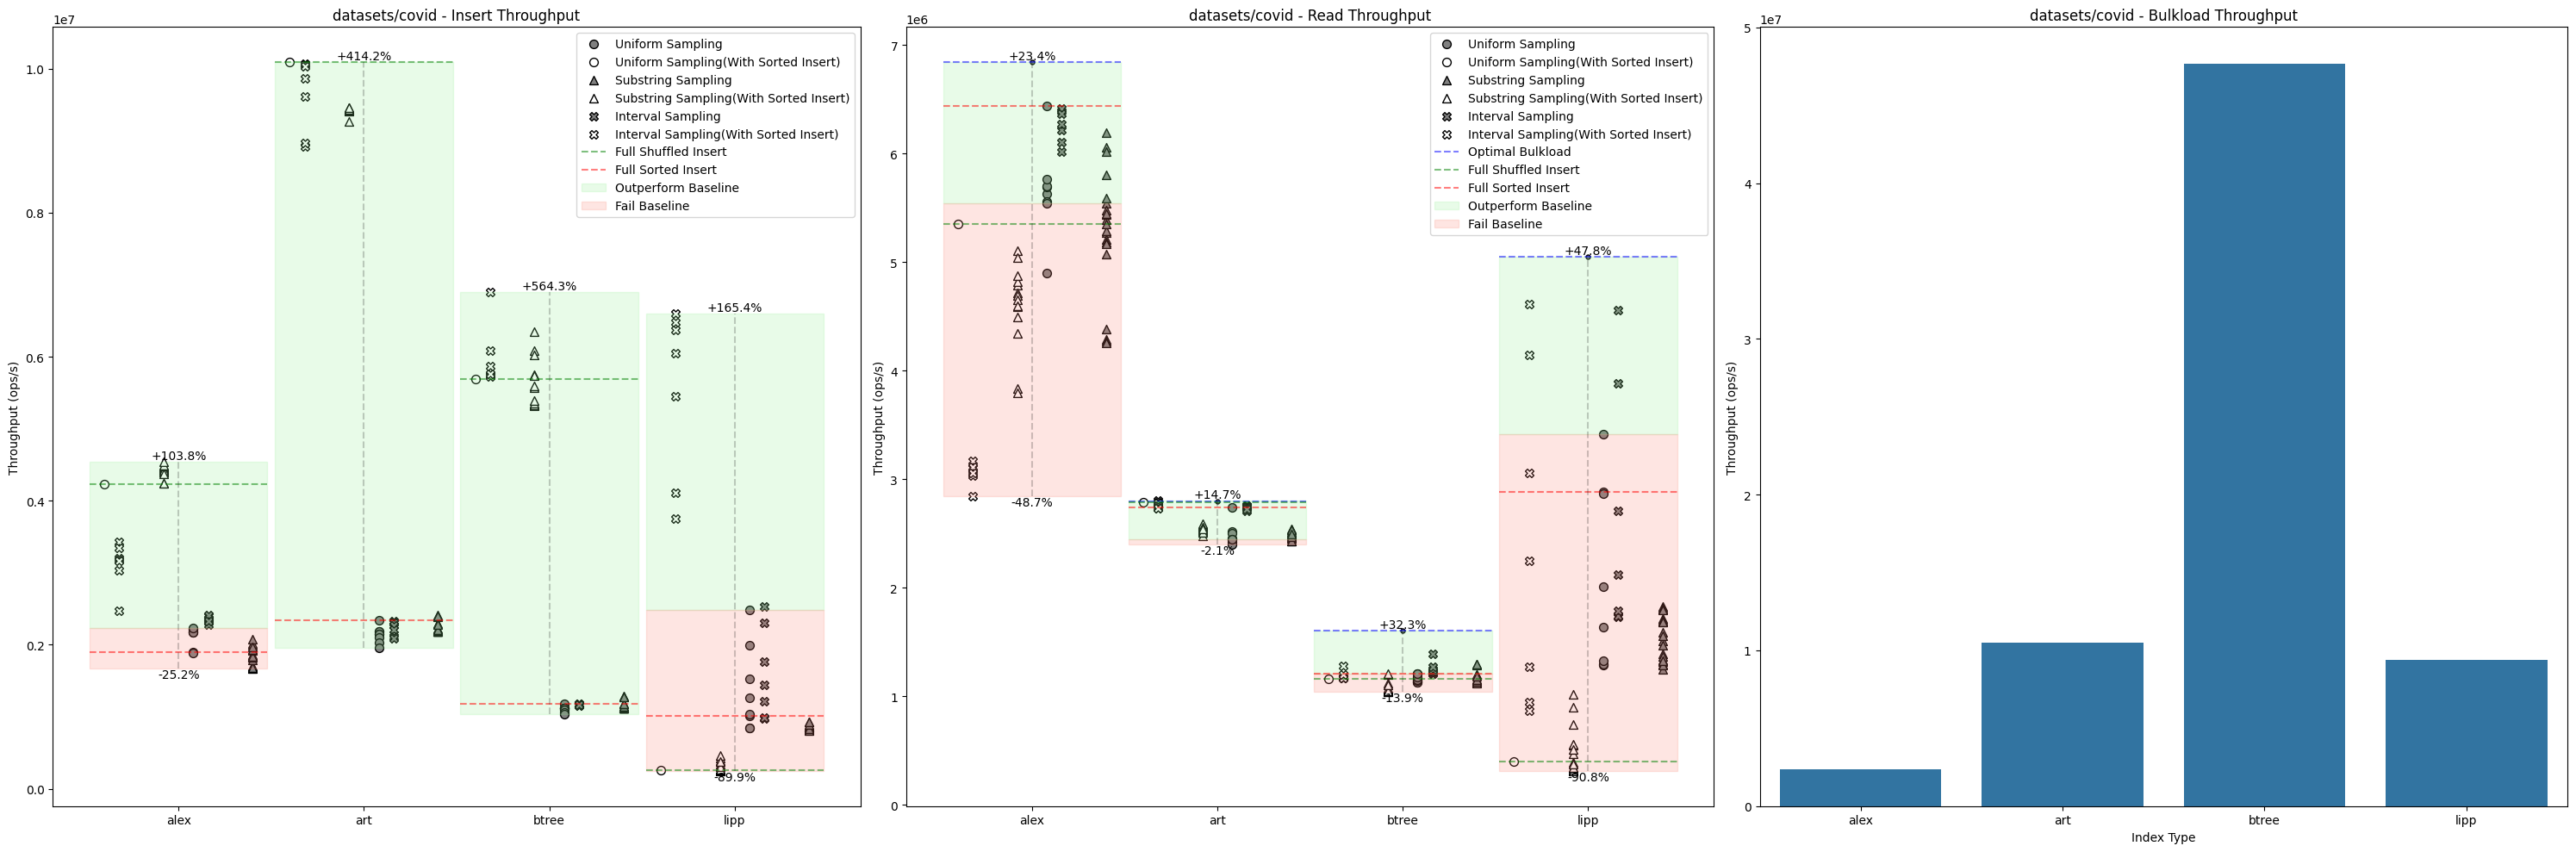

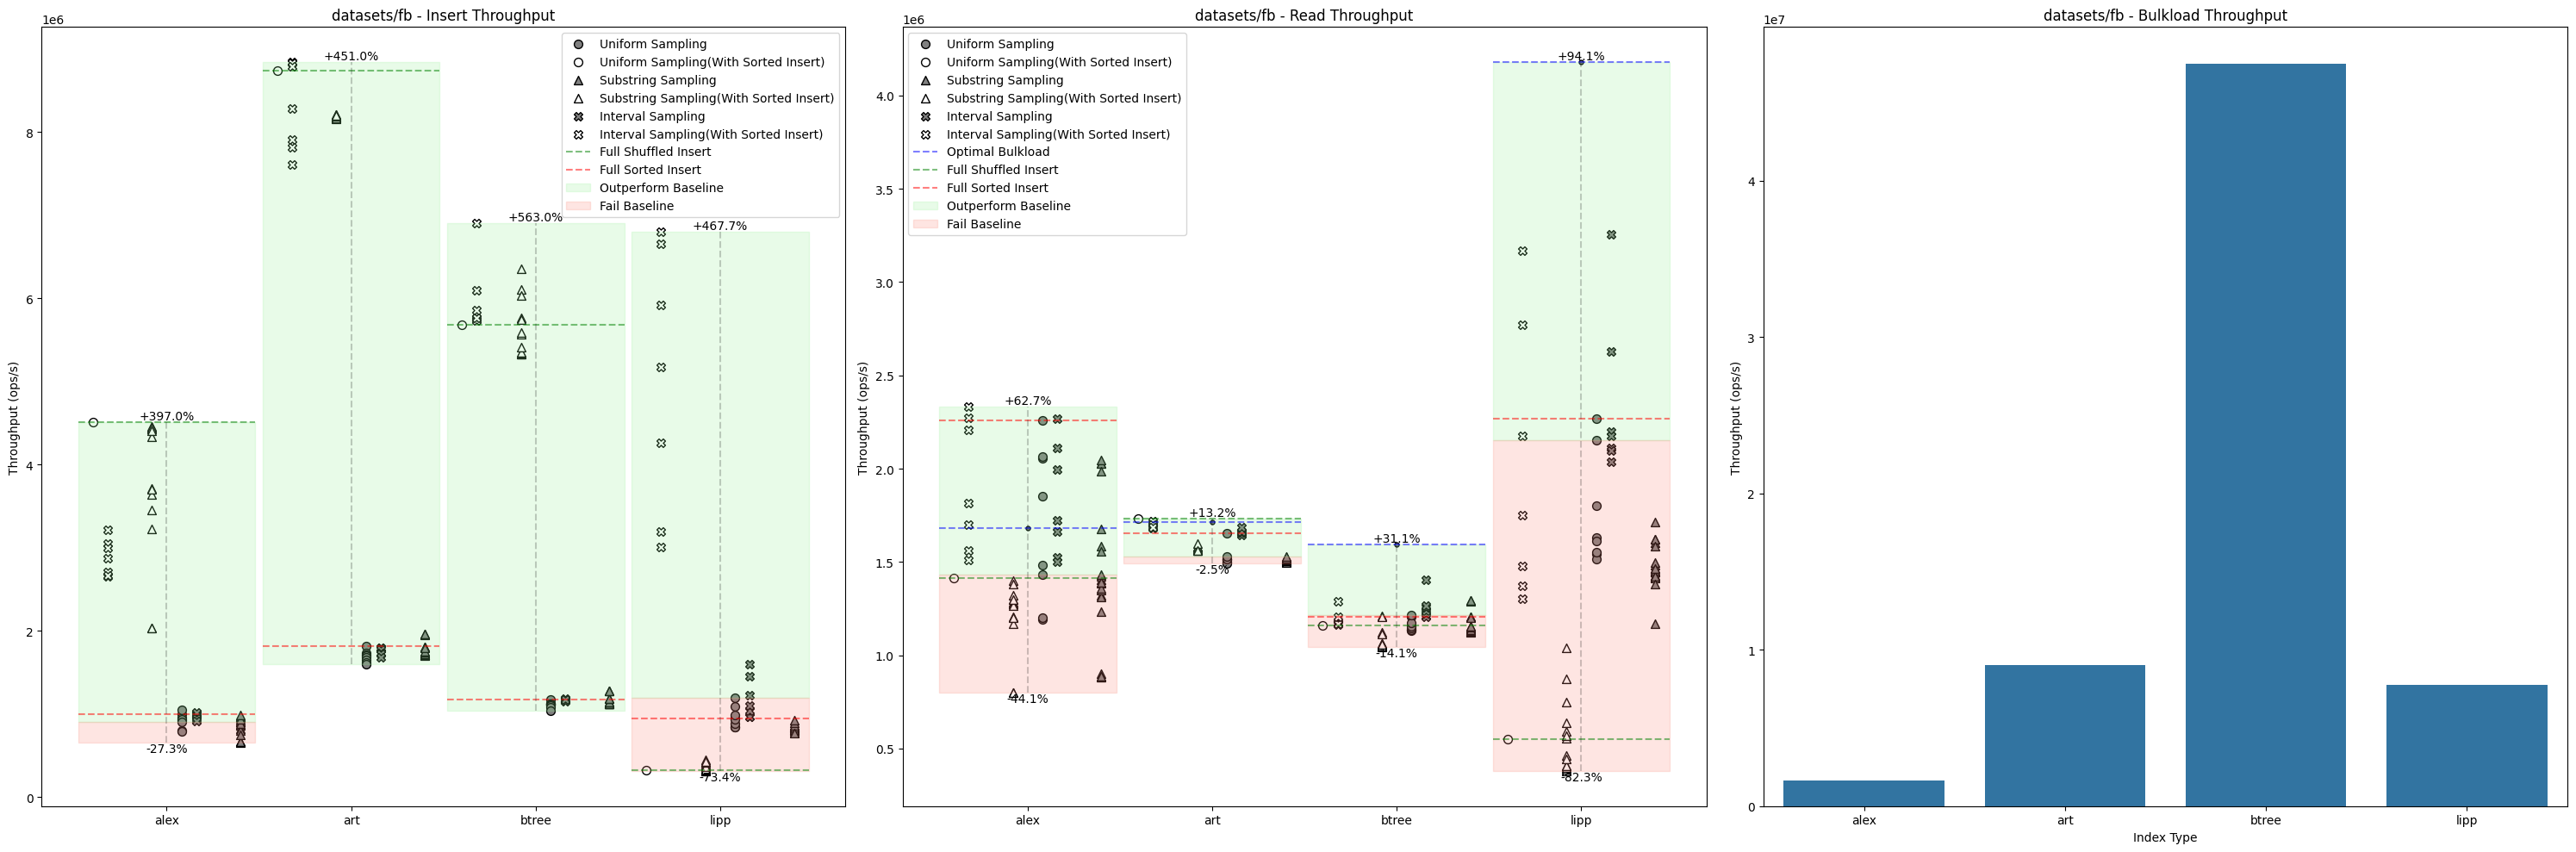

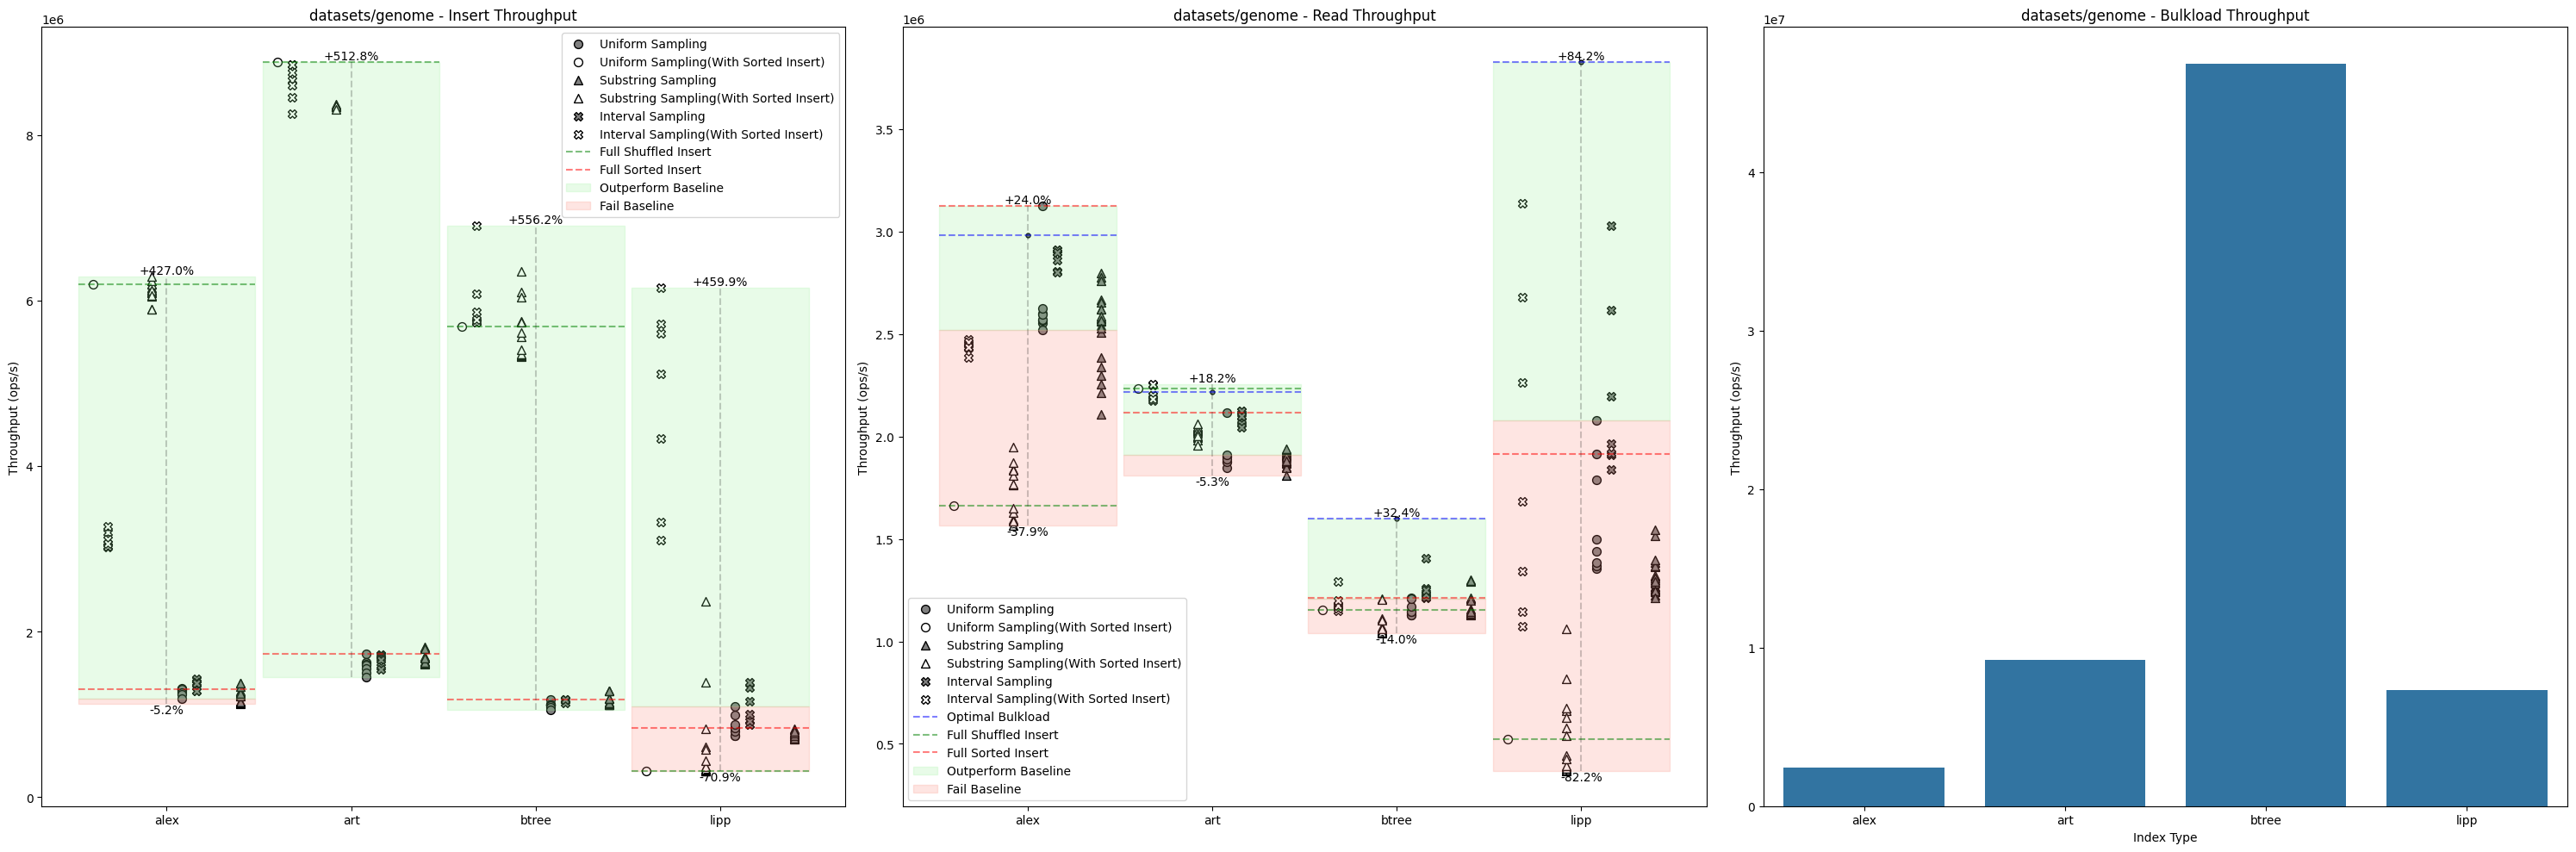

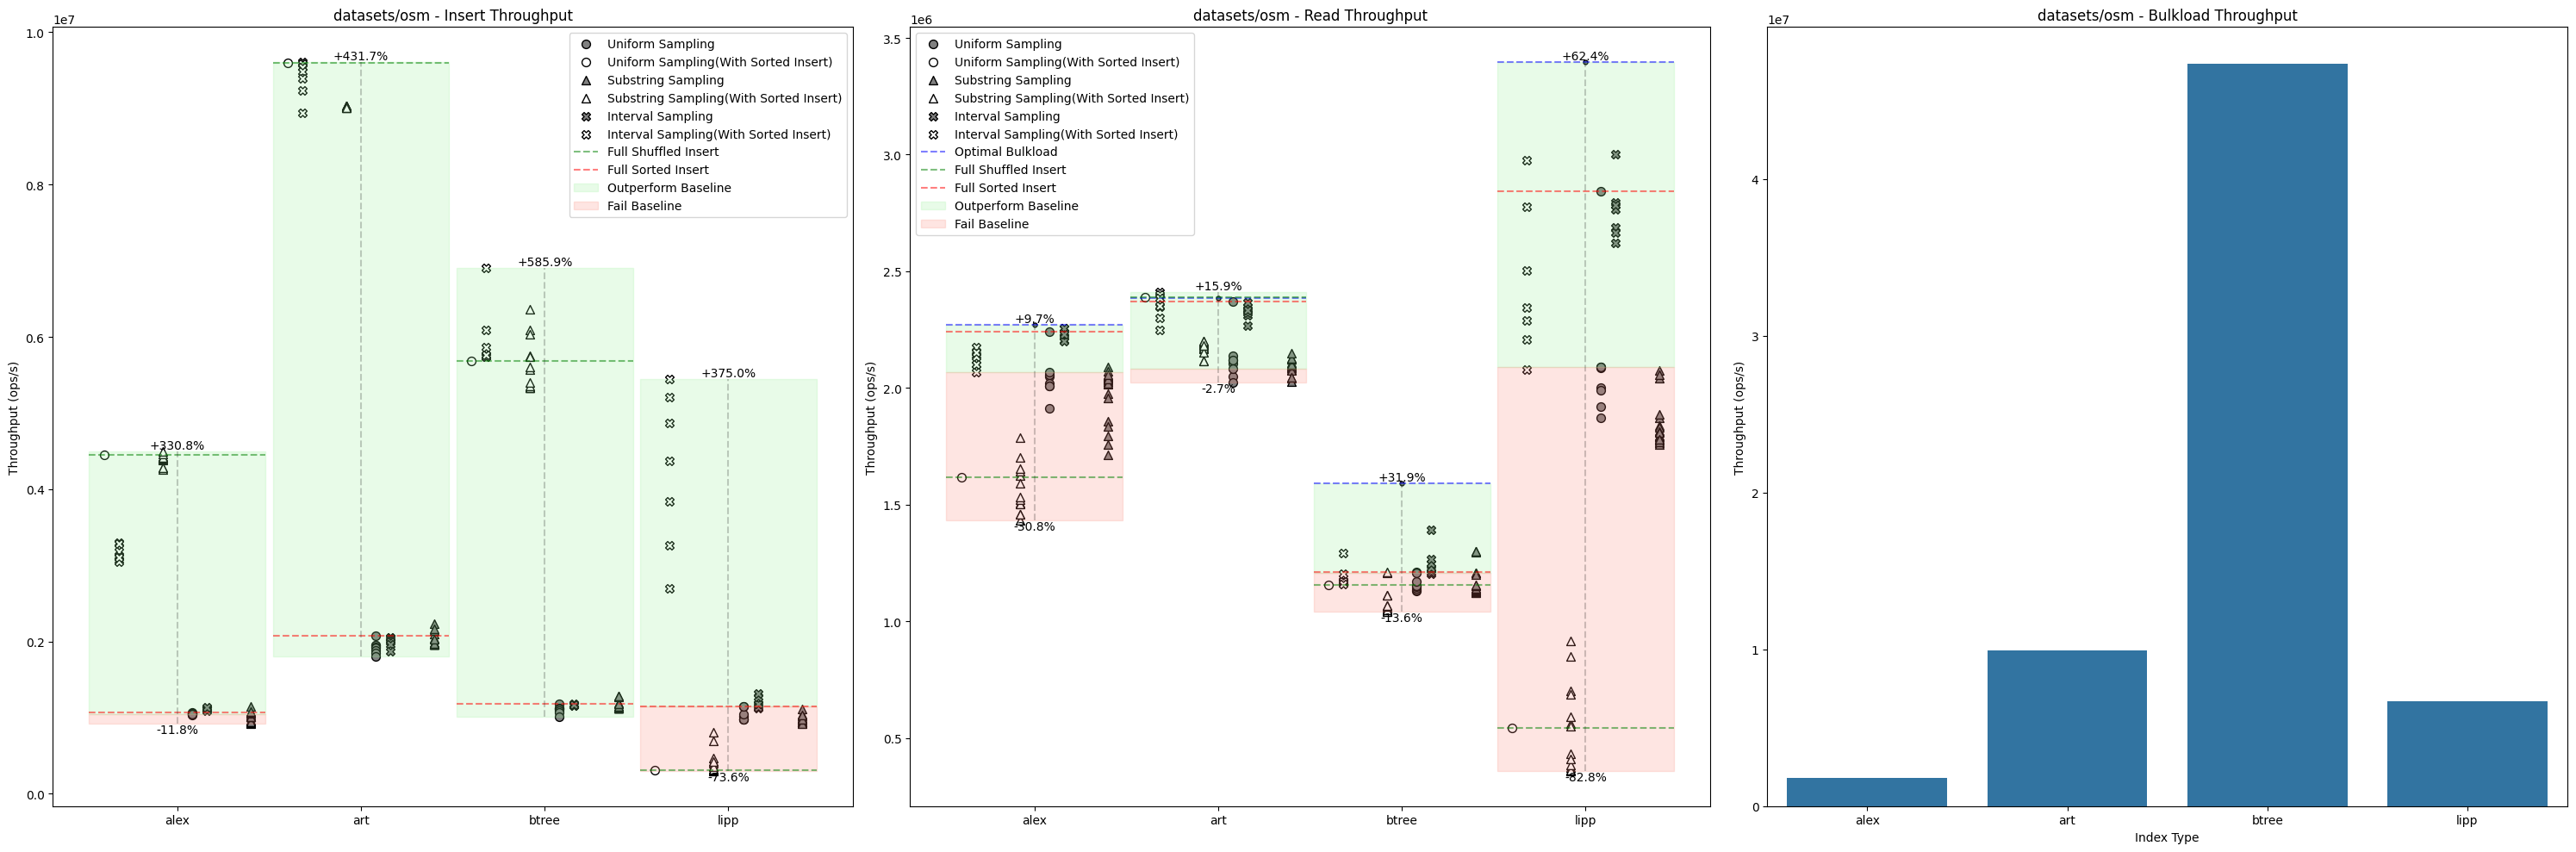

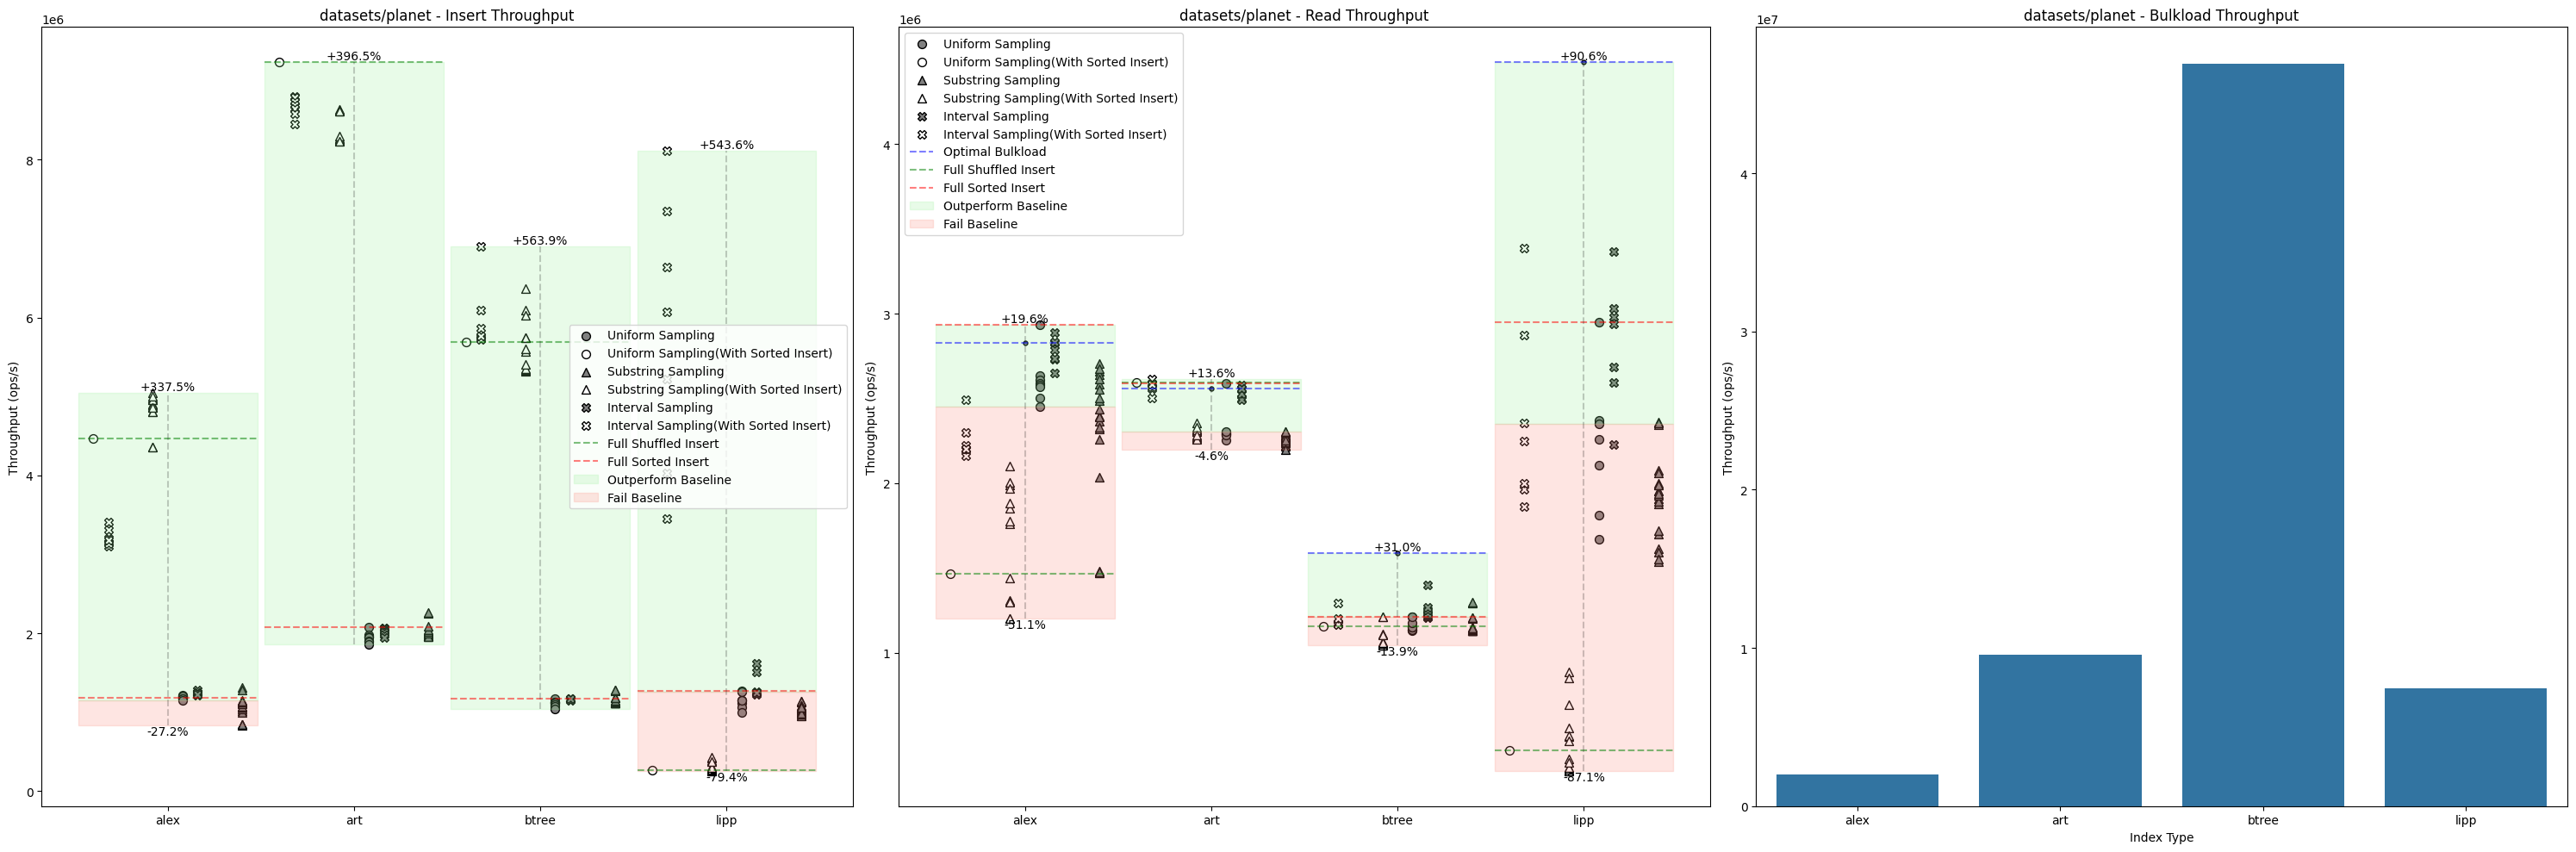

In [26]:
# run this should based on out.csv from 160 result

# throuput scatter plot
# x-axis is different indexs
# y-axis is insert throughput and read throughput for each test suite

# based on the different row, we should use different color


sorted_insert_suites=[999,999999,12,13,9,21,25,23,15,8,7]

bulk_load_whole_data_suites=[9999]

uniform_sampling_suites=[99,999,99999,999999]

interval_sampling_suites=[11,12,13]

normal_sampling_suites=[6,9]

zipfian_sampling_suites=[20,21,22,23,24,25]

substring_sampling_suites=[1,2,3,7,8,10,14,15]

pgm_sampling_suites=[]

gap_size = 0.08

def get_scatter_style(row):
    color = 'gray'
    marker = '.'
    size = 50
    linestyle = '-'
    label = ''
    offset = 0

    if(row['test_suite'] in uniform_sampling_suites):
        marker='o'
        offset = 1*gap_size
        label = 'Uniform Sampling'
    elif(row['test_suite'] in interval_sampling_suites):
        marker='X'
        offset = 2*gap_size
        label = 'Interval Sampling'
    elif(row['test_suite'] in normal_sampling_suites):
        marker='s'
        offset = 3*gap_size
        label = 'Normal Sampling'
    elif(row['test_suite'] in zipfian_sampling_suites):
        marker='D'
        offset = 4*gap_size
        label = 'Zipfian Sampling'
    elif(row['test_suite'] in substring_sampling_suites):
        marker='^'
        offset = 5*gap_size
        label = 'Substring Sampling'
    elif(row['test_suite'] in pgm_sampling_suites):
        marker='*'
        offset = 6*gap_size
        label = 'PGM Sampling'


    if(row['test_suite'] in sorted_insert_suites):
        offset -= 6*gap_size
        # linestyle = ':'
        label += '(With Sorted Insert)'
        color = 'white'
    

    return color, marker, linestyle, label, size, offset

datasets = df_new['key_path'].unique()
index_types = df_new['index_type'].unique().tolist()
index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}
for dataset in datasets:
    df_dataset = df_new[df_new['key_path'] == dataset]
    
    # 分离bulkload和其他test_suite
    df_bulkload = df_dataset[df_dataset['test_suite'] == 9999]
    df_other = df_dataset[df_dataset['test_suite'] != 9999]
    
    # 得到baseline
    baseline = df_dataset[(df_dataset['test_suite'] == 99) & (df_dataset['init_table_size'] == 100000000)]
    full_shuffled = df_dataset[(df_dataset['test_suite'] == 999999) & (df_dataset['init_table_size'] == 0)]
    full_sorted = df_dataset[(df_dataset['test_suite'] ==  99999) & (df_dataset['init_table_size'] == 0)]
    # 得到insert throughput的上界和下界
    insert_throughput_bounds = df_other.groupby('index_type')['insert_throughput_avg'].agg(['min', 'max'])# 这里得是df_other，避免bulkload的吞吐量对上下界的影响

    # 得到baseline
    # baseline = df_dataset[(df_dataset['test_suite'] == 99) & (df_dataset['init_table_size'] == 100000000)]
    read_optimal = df_dataset[df_dataset['test_suite'] == 9999]
    # full_shuffled = df_dataset[(df_dataset['test_suite'] == 999999) & (df_dataset['init_table_size'] == 0)]
    # full_shuffled = df_dataset[(df_dataset['test_suite'] ==  99999) & (df_dataset['init_table_size'] == 0)]
    # 得到read throughput的上界和下界
    read_throughput_bounds = df_dataset.groupby('index_type')['read_throughput_avg'].agg(['min', 'max'])

    fig, axs = plt.subplots(1, 3, figsize=(30, 10), sharey=False)  # 创建三个并列的图，共享y轴
    
#################################################################################################

    # insert throughput scatter plot
    for i, row in df_other.iterrows():
        color, marker, linestyle,label, size, offset = get_scatter_style(row)
        axs[0].scatter(index_type_to_num[row['index_type']] + offset, row['insert_throughput_avg'], color=color,label=label, s=size, marker=marker, linestyle=linestyle, edgecolors='black')
    
    
    axs[0].set_title(f'{dataset} - Insert Throughput')
    axs[0].set_ylabel('Throughput (ops/s)')
    axs[0].set_xticks(range(len(index_types)))
    axs[0].set_xticklabels(index_types)
    # axs[0].legend()
    
    # insert baseline
    for i in range(len(baseline)):
        baseline_throughput = baseline['insert_throughput_avg'].values[i]
        full_shuffled_throughput = full_shuffled['insert_throughput_avg'].values[i]
        full_sorted_throughput = full_sorted['insert_throughput_avg'].values[i]
        # axs[0].plot([i - gap_size*6, i + gap_size*6], [baseline_throughput, baseline_throughput], color='r', linestyle='--')
        axs[0].plot([i - gap_size*6, i + gap_size*6], [full_shuffled_throughput, full_shuffled_throughput],label='Full Shuffled Insert', color='green', linestyle='--', alpha=0.5)
        axs[0].plot([i - gap_size*6, i + gap_size*6], [full_sorted_throughput, full_sorted_throughput],label='Full Sorted Insert', color='red', linestyle='--', alpha=0.5)
    
    # 在scatterplot上添加一个填充的区域，表示吞吐量的上界和下界
    for i, (index_type, bounds) in enumerate(insert_throughput_bounds.iterrows()):
        baseline_throughput = baseline['insert_throughput_avg'].values[i]
        # 如果上界大于baseline，则填充浅绿色
        if bounds['max'] > baseline_throughput:
            axs[0].fill_between([i - gap_size*6, i + gap_size*6], baseline_throughput, bounds['max'], label='Outperform Baseline', color='lightgreen', alpha=0.2)
            # 计算正百分比
            positive_percentage = (bounds['max'] - baseline_throughput) / baseline_throughput * 100
            # 在合适的位置添加文本
            axs[0].text(i, bounds['max'], f'+{positive_percentage:.1f}%', ha='center', va='bottom')
        # 如果下界小于baseline，则填充浅红色
        if bounds['min'] < baseline_throughput:
            axs[0].fill_between([i - gap_size*6, i + gap_size*6], bounds['min'], baseline_throughput, label='Fail Baseline', color='salmon', alpha=0.2)
            # 计算负百分比
            negative_percentage = (bounds['min'] - baseline_throughput) / baseline_throughput * 100
            # 在合适的位置添加文本
            axs[0].text(i, bounds['min'], f'{negative_percentage:.1f}%', ha='center', va='top')
        # 区域内补充一条居中垂直的虚线，用来区分两块区域
        axs[0].plot([i, i], [insert_throughput_bounds['min'][index_type], insert_throughput_bounds['max'][index_type]], color='black', linestyle='--', alpha=0.2)

    # plot legend
    handles, labels = axs[0].get_legend_handles_labels()
    unique_labels = {}
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels[label] = handle
    axs[0].legend(unique_labels.values(), unique_labels.keys())
#################################################################################################

    # read throughput scatter plot
    for i, row in df_dataset.iterrows():
        color, marker, linestyle,label, size, offset = get_scatter_style(row)
        axs[1].scatter(index_type_to_num[row['index_type']] + offset, row['read_throughput_avg'], color=color,label=label, s=size, marker=marker, linestyle=linestyle, edgecolors='black')
    
    axs[1].set_title(f'{dataset} - Read Throughput')
    axs[1].set_ylabel('Throughput (ops/s)')
    axs[1].set_xticks(range(len(index_types)))
    axs[1].set_xticklabels(index_types)
    # axs[1].legend()

    
    # read baseline
    for i in range(len(baseline)):
        baseline_throughput = baseline['read_throughput_avg'].values[i]
        optimal_throuput = read_optimal['read_throughput_avg'].values[i]
        full_shuffled_throughput = full_shuffled['read_throughput_avg'].values[i]
        full_sorted_throughput = full_sorted['read_throughput_avg'].values[i]
        # axs[1].plot([i - gap_size*6, i + gap_size*6], [baseline_throughput, baseline_throughput], color='b', linestyle='--')
        axs[1].plot([i - gap_size*6, i + gap_size*6], [optimal_throuput, optimal_throuput],label='Optimal Bulkload', color='blue', linestyle='--', alpha=0.5)
        axs[1].plot([i - gap_size*6, i + gap_size*6], [full_shuffled_throughput, full_shuffled_throughput],label='Full Shuffled Insert', color='green', linestyle='--', alpha=0.5)
        axs[1].plot([i - gap_size*6, i + gap_size*6], [full_sorted_throughput, full_sorted_throughput],label='Full Sorted Insert', color='red', linestyle='--', alpha=0.5)
    # 在scatterplot上添加一个填充的区域，表示吞吐量的上界和下界
    for i, (index_type, bounds) in enumerate(read_throughput_bounds.iterrows()):
        baseline_throughput = baseline['read_throughput_avg'].values[i]
        # 如果上界大于baseline，则填充浅绿色
        if bounds['max'] > baseline_throughput:
            axs[1].fill_between([i - gap_size*6, i + gap_size*6], baseline_throughput, bounds['max'], label='Outperform Baseline', color='lightgreen', alpha=0.2)
            # 计算正百分比
            positive_percentage = (bounds['max'] - baseline_throughput) / baseline_throughput * 100
            # 在合适的位置添加文本
            axs[1].text(i, bounds['max'], f'+{positive_percentage:.1f}%', ha='center', va='bottom')
        # 如果下界小于baseline，则填充浅红色
        if bounds['min'] < baseline_throughput:
            axs[1].fill_between([i - gap_size*6, i + gap_size*6], bounds['min'], baseline_throughput, label='Fail Baseline', color='salmon', alpha=0.2)
            # 计算负百分比
            negative_percentage = (bounds['min'] - baseline_throughput) / baseline_throughput * 100
            # 在合适的位置添加文本
            axs[1].text(i, bounds['min'], f'{negative_percentage:.1f}%', ha='center', va='top')
        # 区域内补充一条居中垂直的虚线，用来区分两块区域
        axs[1].plot([i, i], [read_throughput_bounds['min'][index_type], read_throughput_bounds['max'][index_type]], color='black', linestyle='--', alpha=0.2)
        
    # plot legend
    handles, labels = axs[1].get_legend_handles_labels()
    unique_labels = {}
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels[label] = handle
    axs[1].legend(unique_labels.values(), unique_labels.keys())
#################################################################################################

    # bulkload吞吐量图
    sns.barplot(x='index_type', y='insert_throughput_avg', data=df_bulkload, ax=axs[2])
    axs[2].set_title(f'{dataset} - Bulkload Throughput')
    axs[2].set_ylabel('Throughput (ops/s)')
    axs[2].set_xlabel('Index Type')
    
    plt.tight_layout()  # 确保子图不会重叠
    plt.show()

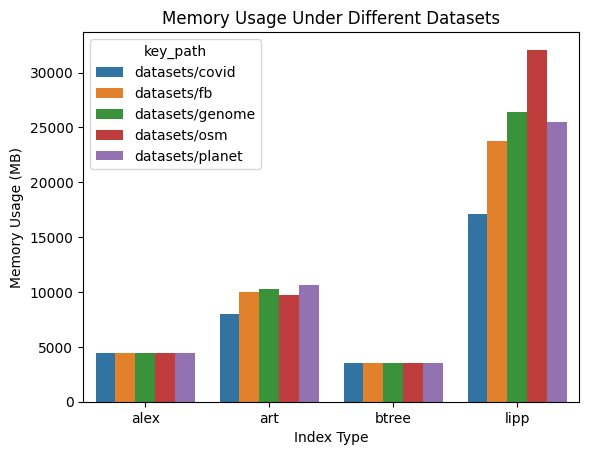

In [23]:
# run this should based on out.csv from 160 result
# memory usage bar chart
# x-axis is different indexs
# y-axis is memory usage under different datasets
df_dataset = df_new[df_new['test_suite'] == 9999]
df_dataset.loc[:, 'memory_consumption_avg'] = df_dataset['memory_consumption_avg'] / (2**20)
sns.barplot(x='index_type', y='memory_consumption_avg',hue='key_path', data=df_dataset)
plt.title(f'Memory Usage Under Different Datasets')
plt.ylabel('Memory Usage (MB)')
plt.xlabel('Index Type')
plt.show()


In [24]:
# # run this should based on out.csv from BaseLineTest

# # throuput scatter plot
# # x-axis is different indexs
# # y-axis is insert throughput and read throughput for each test suite
# datasets = df_new['key_path'].unique()
# for dataset in datasets:
#     df_dataset = df_new[df_new['key_path'] == dataset]
    
#     # 分离bulkload和其他test_suite
#     df_bulkload = df_dataset[df_dataset['test_suite'] == 9999]
#     df_other = df_dataset[df_dataset['test_suite'] != 9999]
    
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # 创建三个并列的图，共享y轴
    
#     # 插入吞吐量图
#     sns.scatterplot(x='index_type', y='insert_throughput_avg', data=df_other, ax=axs[0], color='blue')
#     axs[0].set_title(f'{dataset} - Insert Throughput')
#     axs[0].set_ylabel('Throughput (ops/s)')
#     axs[0].set_xlabel('Index Type')
    
#     # 读取吞吐量图
#     sns.scatterplot(x='index_type', y='read_throughput_avg', data=df_dataset, ax=axs[1], color='red')
#     axs[1].set_title(f'{dataset} - Read Throughput')
#     axs[1].set_ylabel('Throughput (ops/s)')
#     axs[1].set_xlabel('Index Type')
    
#     # bulkload吞吐量图
#     sns.barplot(x='index_type', y='insert_throughput_avg', data=df_bulkload, ax=axs[2])
#     axs[2].set_title(f'{dataset} - Bulkload Throughput')
#     axs[2].set_ylabel('Throughput (ops/s)')
#     axs[2].set_xlabel('Index Type')
    
#     plt.tight_layout()  # 确保子图不会重叠
#     plt.show()